### Calculate the policy of the agent
* State Variable: x = [w, n, e, s, A], action variable a = [c, b, k], both of them are numpy array 

In [11]:
%pylab inline
# import constant variables and header files
from header import *
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


In [12]:
# Define the transition of state
def transition(x, a, t):
    '''
         Input: x current state: (w, n, s, e, A)
                a action taken: (c, b, k)
         Output: the next possible states with corresponding probabilities
    '''
    # unpack variable
    c, b, k = a
    w, n, s, e, A = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    # Agent is dead at the end of last period
    if A == 0:
        for s_next in [0,1]:
            x_next.append([0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    # Agent is alive
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
   
            # for potential s_next, e_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for e_next in [0,1]:
                    for A_next in [0,1]:
                        x_next.append([w_next, n_next, s_next, e_next, A_next])
                        prob_next.append(Ps[int(s),s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])

        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
   
            # for potential s_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Ps[int(s), s_next])

    return np.array(x_next), np.array(prob_next)

In [38]:
# Value function is a function of state and time t
def V(x, t, Vmodel):
    # Define the objective function as a function of action
    w, n, s, e, A = x
    if A == 0:
        return np.array([R(x,[0,0,0]),[0,0,0]])
    else: 
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        n_discount = n/discounting
        ytx = y(t, x)
        
        def obj(thetaTheta):
            theta1,theta2 = thetaTheta
            if t < T_R:
                if e == 1:
                    bk = ((1-tau_L)*(ytx * 0.95) + w) * theta1
                    c = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1)
                else:
                    bk = ((1-tau_L)*ytx + w) * theta1
                    c = ((1-tau_L)*ytx + w) * (1-theta1)
            else:
                bk = ((1-tau_R)*ytx + w + n_discount) * theta1
                c = ((1-tau_R)*ytx + w + n_discount) * (1-theta1)
            b = bk * theta2
            k = bk * (1-theta2)
            a = (c,b,k)
            x_next, prob_next = transition(x, a, t)
            
            V_tilda = []
            for xx in x_next:
                V_tilda.append(Vmodel[int(xx[2])][int(xx[3])][int(xx[4])].ev(xx[0], xx[1]))
                
            return -(R(x, a) + beta * np.dot(V_tilda, prob_next))
        
        res = optimize.minimize(obj, [0.5, 0.5], method="SLSQP",bounds = ((0, 1), (0, 1)), tol = 1e-9)
        xopt = res.x
        max_val = -res.fun
        theta1_m, theta2_m = xopt
        
        if t < T_R:
            if e == 1:
                bk_m = ((1-tau_L)*(ytx * 0.95) + w) * theta1_m
                c_m = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1_m)
            else:
                bk_m = ((1-tau_L)*ytx + w) * theta1_m
                c_m = ((1-tau_L)*ytx + w) * (1-theta1_m)
        else:
            bk_m = ((1-tau_R)*ytx + w + n_discount) * theta1_m
            c_m = ((1-tau_R)*ytx + w + n_discount) * (1-theta1_m)
        b_m = bk_m * theta2_m
        k_m = bk_m * (1-theta2_m)
        return np.array([max_val, [c_m, b_m, k_m]])

In [39]:
# wealth discretization 
w_grid_size = 40
w_lower = 3
w_upper = 2000
# 401k amount discretization 
n_grid_size = 20
n_lower = 3
n_upper = 1000
power = 2

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)

# initialize the state discretization 
x_T = np.array([[w,n,e,s,0]   for w in powspace(w_lower, w_upper, power, w_grid_size)
                            for n in powspace(n_lower, n_upper, power, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

xgrid = np.array([[w,n,e,s,A] for w in powspace(w_lower, w_upper, power, w_grid_size)
                            for n in powspace(n_lower, n_upper, power, n_grid_size)
                            for s in [0,1]
                            for e in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

Vgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = x_T):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))))).reshape((w_grid_size, n_grid_size, 2,2,2))

Vgrid[:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0]), x = x_T)

### Backward Induction Part

In [40]:
%%time 
ws = powspace(w_lower, w_upper, power, w_grid_size)
ns = powspace(n_lower, n_upper, power, n_grid_size)

xs = xgrid.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))

pool = Pool()

for t in range(T_max-1, -1, -1):
    print(t)  
    cs = [[[RS(ws, ns, Vgrid[:,:,s,e,A,t+1], kx = 1, ky = 1) for A in [0,1]] for e in [0,1]] for s in [0,1]]
    f = partial(V, t = t, Vmodel = cs)
    results = np.array(pool.map(f, xs))   
    Vgrid[:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size, 2,2,2))
    #########################################################[test function part] 
#     fig = plt.figure(figsize = [12, 8])
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z=Vgrid[:,:,1,1,1,t])
#     plt.show()
    #########################################################
    cgrid[:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    bgrid[:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    kgrid[:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
pool.close()

69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
CPU times: user 19.5 s, sys: 4.01 s, total: 23.5 s
Wall time: 3min 51s


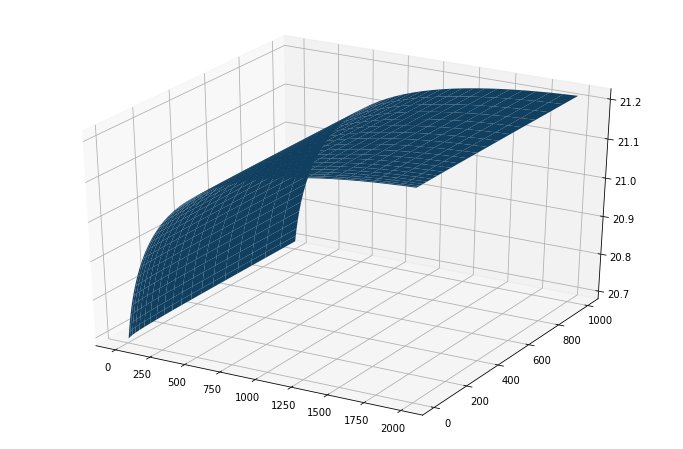

In [26]:
fig = plt.figure(figsize = [12, 8])
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X = xgrid[:,:,1,1,1,0], Y = xgrid[:,:,1,1,1,1], Z=Vgrid[:,:,1,1,1,0])
plt.show()

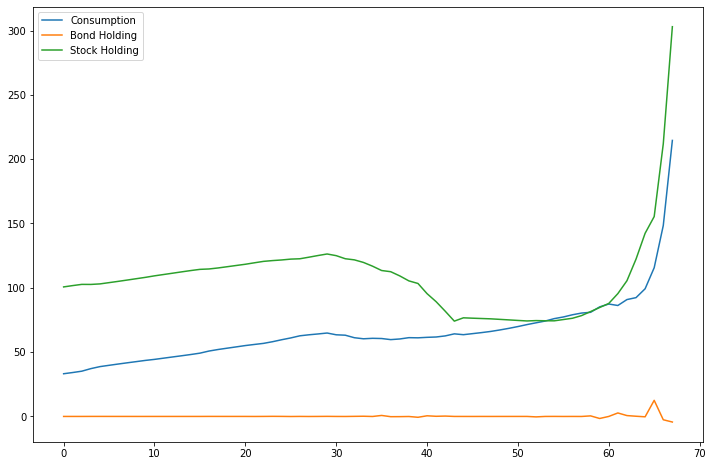

In [41]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, C = cgrid, B = bgrid, K = kgrid):
    c = []
    b = []
    k = []
    for t in range(1,T_max-1):
        c.append(RS(ws, ns, C[:,:,s,e,A,t])(w_level, n_level)[0])
        b.append(RS(ws, ns, B[:,:,s,e,A,t])(w_level, n_level)[0])
        k.append(RS(ws, ns, K[:,:,s,e,A,t])(w_level, n_level)[0])
    plt.figure(figsize = [12,8])
    plt.plot(c, label = "Consumption")
    plt.plot(b, label= "Bond Holding")
    plt.plot(k, label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(100, 100, 1, 1, 1)

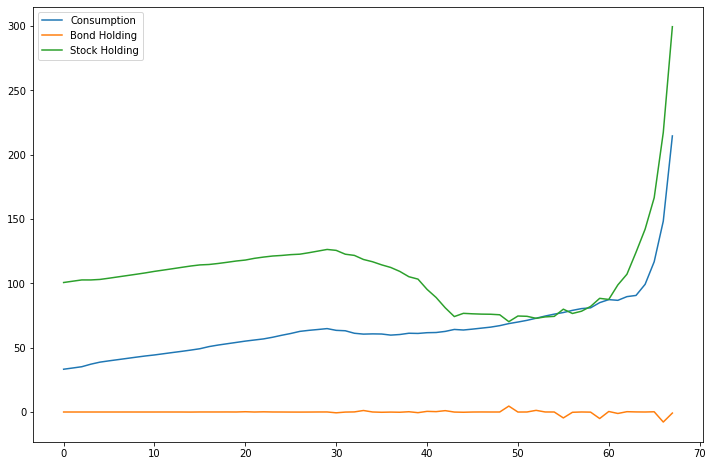

In [34]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, C = cgrid, B = bgrid, K = kgrid):
    c = []
    b = []
    k = []
    for t in range(1,T_max-1):
        c.append(RS(ws, ns, C[:,:,s,e,A,t])(w_level, n_level)[0])
        b.append(RS(ws, ns, B[:,:,s,e,A,t])(w_level, n_level)[0])
        k.append(RS(ws, ns, K[:,:,s,e,A,t])(w_level, n_level)[0])
    plt.figure(figsize = [12,8])
    plt.plot(c, label = "Consumption")
    plt.plot(b, label= "Bond Holding")
    plt.plot(k, label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(100, 100, 1, 1, 1)

In [6]:
# np.save("Vgrid", Vgrid)
# np.save("cgrid", cgrid)
# np.save("bgrid", bgrid)
# np.save("kgrid", kgrid)

In [7]:
# ws = powspace(w_lower, w_upper, 3, w_grid_size)
# ns = powspace(n_lower, n_upper, 3, n_grid_size)
# Vgrid = np.load("Vgrid.npy")
# cgrid = np.load("cgrid.npy")
# bgrid = np.load("bgrid.npy")
# kgrid = np.load("kgrid.npy")

### Summary Plot 

### Simulation Part

In [9]:
import quantecon as qe
mc = qe.MarkovChain(Ps)

def action(t, x):
    w,n,s,e,A = x
    if A == 1:
        c = RS(ws, ns, cgrid[:,:,s,e,A,t])(w, n)[0][0]
        b = RS(ws, ns, bgrid[:,:,s,e,A,t])(w, n)[0][0]
        k = RS(ws, ns, kgrid[:,:,s,e,A,t])(w, n)[0][0]
    else:
        c = 0
        b = 0
        k = 0
    return (c,b,k)

# Define the transition of state
def transition(x, a, t, s_next):
    '''
        Input: x current state: (w, n, s, e, A) 
               a action taken: (c, b, k)
        Output: the next possible states with corresponding probabilities
    '''
    # unpack variable
    c, b, k = a
    w, n, s, e, A = x
    # variables used to collect possible states and probabilities 
    x_next = []
    prob_next = []
    # Agent is dead at the end of last period
    if A == 0:
        return np.array([0, 0, s_next, 0, 0])
    # Agent is alive 
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next 
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
                
            # for potential s_next, e_next and A_next 
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            for e_next in [0,1]:
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Pe[int(s),s_next,int(e),e_next])    
                
        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
            
            # for potential s_next and A_next
            r_stock = r_m[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            for A_next in [0,1]:
                x_next.append([w_next, n_next, s_next, e_next, A_next])
                prob_next.append(Pat[A_next])   
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]]

In [10]:
numEcon = 500
sim = 1000
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcon)]
# simulate an agent age 0 starting with wealth of 20 and 20 in rFund.
def simulateAgent(i):
    # states
    wealth = []
    rFund = []
    employ = []
    live = []
    Salary = []
    # actions 
    Consumption = []
    Bond = []
    Stock = []
    if np.random.rand() > 0.95:
        x = [20, 0, 0, 0, 1]
    else:
        x = [20, 0, 0, 1, 1]
    econState = EconStates[i//sim]
    for t in range(len(econState)-1):
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, x)
        c, b, k = a
        w, n, _, e, A = x
        
        wealth.append(w)
        rFund.append(n)
        Consumption.append(c)
        Bond.append(b)
        Stock.append(k)
        Salary.append(y(t, x))
        employ.append(e)
        live.append(A)
        x = transition(x, a, t, s_next)
    # list of array 
    return np.array([wealth, rFund, Consumption, Bond, Stock, Salary, employ, live]).T

In [11]:
%%time 
pool = Pool()
agents = pool.map(simulateAgent, list(range(sim*numEcon)))
pool.close()

CPU times: user 9.27 s, sys: 6.11 s, total: 15.4 s
Wall time: 22min 29s


In [12]:
np.save("agents", agents)

### Summary statistics of the simulation 

In [13]:
import numpy as np
agents = np.load("agents.npy")

In [14]:
# wealth, rFund, Consumption, Bond, Stock, Salary, employ, live
def collect(attribute, agents):
    names = ["wealth", "rFund", "Consumption", "Bond", "Stock", "Salary", "employ", "live"]
    index = names.index(attribute)
    container = np.zeros((agents[0].shape[0],len(agents)))
    for i in range(len(agents)):
        container[:, i] = agents[i][:, index]
    return container

In [15]:
wealth = collect("wealth",agents)
rFund = collect("rFund",agents)
Consumption = collect("Consumption",agents)
Bond = collect("Bond",agents)
Stock = collect("Stock",agents)
Salary = collect("Salary",agents)
employ = collect("employ",agents)
live = collect("live",agents)

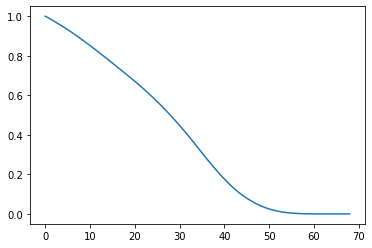

In [16]:
# Population during the entire simulation period
plt.plot(np.mean(live, axis = 1))

In [17]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(live[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(live[i,:] == 1)]))
    return np.array(means)

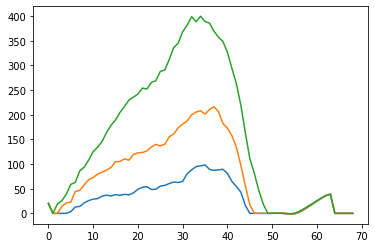

In [18]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(wealth))

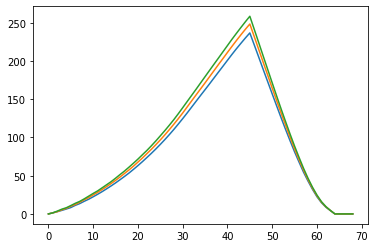

In [19]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(rFund))

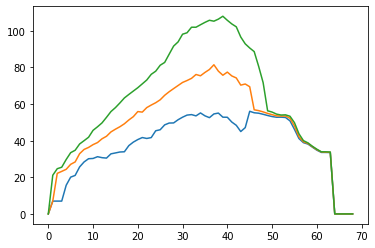

In [20]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Consumption))

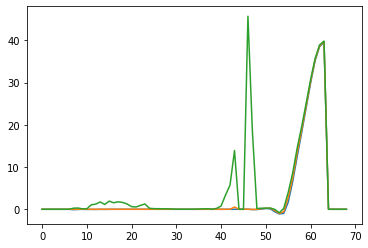

In [21]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Bond))

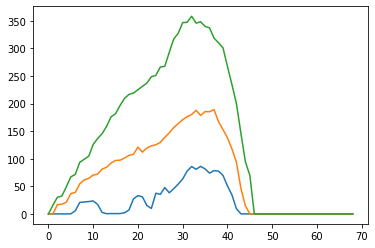

In [22]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Stock))

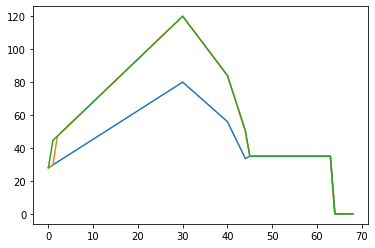

In [23]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Salary))

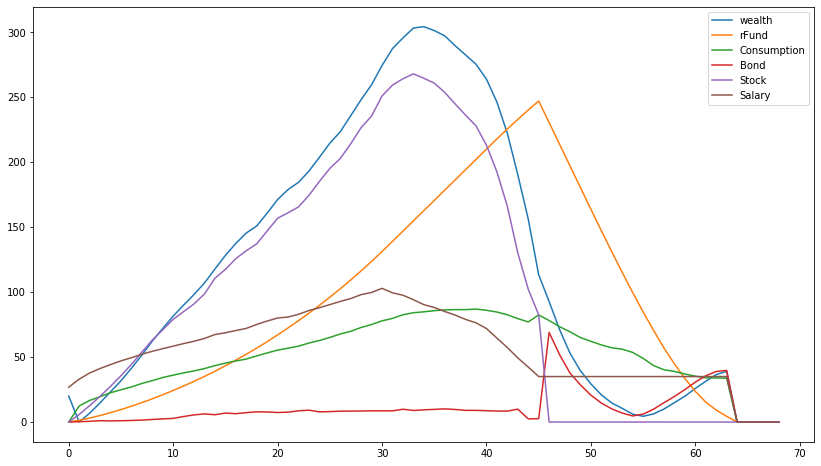

In [24]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(wealth), label = "wealth")
plt.plot(meanForPeopleWholive(rFund), label = "rFund")
plt.plot(meanForPeopleWholive(Consumption), label = "Consumption")
plt.plot(meanForPeopleWholive(Bond), label = "Bond")
plt.plot(meanForPeopleWholive(Stock), label = "Stock")
plt.plot(meanForPeopleWholive(Salary), label = "Salary")
plt.legend()

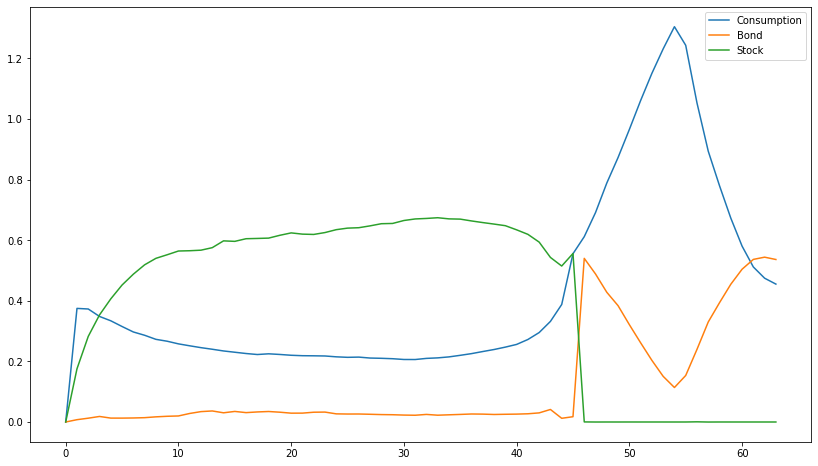

In [25]:
# calculate fraction of consumption, stock investment, bond investment over (wealth + income)
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(Consumption)[:65]/meanForPeopleWholive(wealth+Salary)[:65], label = "Consumption")
plt.plot(meanForPeopleWholive(Bond)[:65]/meanForPeopleWholive(wealth+Salary)[:65], label = "Bond")
plt.plot(meanForPeopleWholive(Stock)[:65]/meanForPeopleWholive(wealth+Salary)[:65], label = "Stock")
plt.legend()

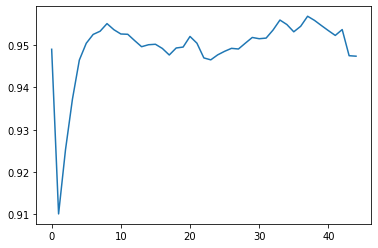

In [26]:
plt.plot(meanForPeopleWholive(employ)[:45])

In [27]:
averageWealth = []
for i in range(5, 46, 5):
    averageWealth.append(meanForPeopleWholive(wealth)[i])

medianWealth = [] 
for i in range(5, 46, 5):
    medianWealth.append(quantileForPeopleWholive(wealth)[i][1])
    
median401k = [] 
for i in range(5, 46, 5):
    median401k.append(quantileForPeopleWholive(rFund)[i][1])
    
    
for t in range(5, 46, 5):
    # x = [w,n,s,e,A]
    i = t//5-1
    for e in [0,1]:
        for s in [0,1]:
            c,b,k = action(t, [medianWealth[i], median401k[i],s,e,1])
            print(k/(k+b), end = " ")
    print()

7.41790672157471e-14 4.596486920074724e-16 0.14516490179115338 1.0 
7.107921727408926e-16 1.2680768001217866e-16 1.013449534568511 1.0015146479259691 
6.161872364001696e-16 -3.944166352636331e-18 0.9961693842321316 1.000118770124514 
-8.19873166272315e-17 -3.3853473145478824e-19 1.0183097013794893 1.0002579779333622 
2.9637344164102908e-16 4.1499435891216246e-16 0.9944781017678763 1.0000045810980076 
-9.559541430827345e-17 2.9807316639837197e-16 1.0047801092081685 0.9999986909651948 
1.187914189813855e-16 2.7508398479487927e-17 1.0019359961701746 1.0000092491225563 
2.67944564956746e-17 2.9975002683184624e-16 1.0020464885527973 0.9999999566596535 
-4.3098445614940916e-05 -4.3098445614940916e-05 0.9999996984970445 0.9999996984970445 


In [28]:
averageWealth

[31.71085824647765,
 81.47798449126185,
 128.21841326032578,
 171.20240802778198,
 214.55703666350612,
 274.3855916617434,
 301.28773330115246,
 263.88292936643927,
 113.35282636320825]

In [29]:
medianWealth

[22.7160125692027,
 72.86729277129886,
 104.92862165362031,
 122.59769350467145,
 136.7869977631488,
 181.21158557491543,
 201.17794425530073,
 172.44011591794649,
 17.26275458350762]

In [30]:
median401k

[10.031575815680002,
 24.89335006982823,
 43.861638302963655,
 67.76641632707653,
 96.77911295586809,
 131.98702380942046,
 171.451324501817,
 211.21712596770251,
 248.39371459492497]